In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('customer_shopping_data.csv').head(500)
df = df.rename(columns={"invoice_date": "date"})
df['date'] = pd.to_datetime(df['date'], format=('%d/%m/%Y'))
df['total_sales'] = df['quantity'] * df['price']
df

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,date,shopping_mall,total_sales
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,7502.00
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,5401.53
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,300.08
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,15004.25
4,I337046,C189076,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,242.40
...,...,...,...,...,...,...,...,...,...,...,...
495,I328822,C230641,Male,51,Food & Beverage,3,15.69,Cash,2022-06-13,Metrocity,47.07
496,I168181,C805154,Male,22,Clothing,3,900.24,Credit Card,2021-07-01,Metrocity,2700.72
497,I108543,C330021,Female,67,Clothing,5,1500.40,Debit Card,2022-07-08,Viaport Outlet,7502.00
498,I120615,C107668,Female,22,Toys,2,71.68,Credit Card,2022-02-02,Istinye Park,143.36


In [3]:
top_products_qty = df.groupby('category')['quantity'].sum().sort_values(ascending=False)
print(f"Best selling products by quantity: {top_products_qty}")

Best selling products by quantity: category
Clothing           475
Cosmetics          263
Food & Beverage    237
Shoes              147
Toys               142
Souvenir           106
Books               94
Technology          69
Name: quantity, dtype: int64


In [4]:
top_products_revenue = df.groupby('category')['total_sales'].sum().sort_values(ascending=False)
print(f"Best selling products by revenue: {top_products_revenue}")

Best selling products by revenue: category
Clothing           530241.36
Shoes              340296.39
Technology         253050.00
Cosmetics           40212.74
Toys                17633.28
Books                6060.00
Souvenir             4973.52
Food & Beverage      4325.21
Name: total_sales, dtype: float64


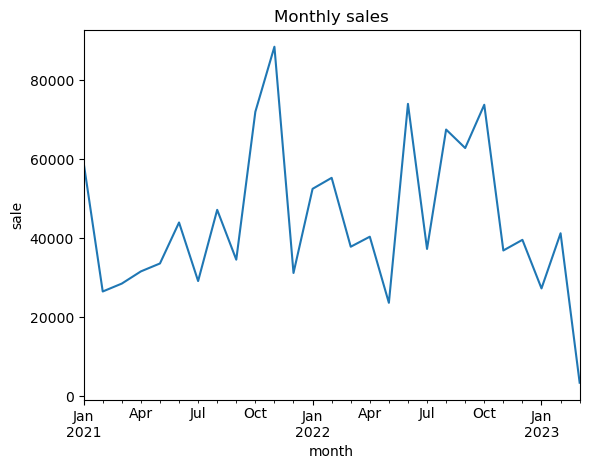

In [5]:
df['month'] = df['date'].dt.to_period('M')
monthly_sales = df.groupby('month')['total_sales'].sum()

monthly_sales.plot(kind='line', title='Monthly sales')
plt.xlabel('month')
plt.ylabel('sale')
plt.show()

In [6]:
desc_stats = df[['total_sales', 'quantity', 'price']].describe()
desc_stats

,total_sales,quantity,price
count,500.0000,500.00000,500.000000
mean,2393.5850,3.06600,645.805680
std,4092.4921,1.42045,920.660562
min,5.2300,1.00000,5.230000
25%,141.6075,2.00000,46.552500
50%,378.7500,3.00000,179.200000
75%,2700.7200,4.00000,1200.320000
max,26250.0000,5.00000,5250.000000


In [7]:
correlation = df[['total_sales', 'quantity', 'price']].corr()
correlation

,total_sales,quantity,price
total_sales,1.000000,0.440811,0.959812
quantity,0.440811,1.000000,0.316859
price,0.959812,0.316859,1.000000


In [8]:
max_date = df['date'].max()
recency = df.groupby('customer_id')['date'].max().apply(lambda x: (max_date - x).days)
frequency = df['customer_id'].value_counts()
monetary = df.groupby('customer_id')['total_sales'].sum()

rfm = pd.DataFrame({'Recency':recency, 'Frequency':frequency, 'Monetary':monetary})

rfm['R_Score'] = pd.qcut(rfm['Recency'].rank(method='first'), 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'].rank(method='first'), 4, labels=[1, 2, 3, 4])

rfm['RFM_Score'] = rfm['M_Score'].astype(int) + rfm['F_Score'].astype(int) + rfm['R_Score'].astype(int)

def rfm_segment(row):
    if row['RFM_Score'] >= 9:
        return 'VIP'
    if row['RFM_Score'] >= 6:
        return 'Loyal'
    if row['RFM_Score'] >= 4:
        return 'Active'
    else:
        return 'usual'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

print(rfm.sort_values('RFM_Score', ascending=False).head(5))

             Recency  Frequency  Monetary R_Score F_Score M_Score  RFM_Score  \
customer_id                                                                    
C387164           34          1  16800.00       4       4       4         12   
C545065          167          1   4801.28       4       4       4         12   
C333065          155          1  26250.00       4       4       4         12   
C617884          128          1   9450.00       4       4       4         12   
C616106           91          1   4801.28       4       4       4         12   

            Segment  
customer_id          
C387164         VIP  
C545065         VIP  
C333065         VIP  
C617884         VIP  
C616106         VIP  


In [20]:
x = df[['date']]
y = df['total_sales']

y = np.array(y)
x = np.array(x)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train.shape, x_test.shape

((400, 1), (100, 1))

In [23]:
model = GradientBoostingRegressor(n_estimators=200, random_state=42)
model.fit(x_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [24]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

In [27]:
train_error = mean_squared_error(y_train, y_pred_train)
test_error = mean_squared_error(y_test, y_pred_test)